In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#讀取資料集
import pandas as pd
import numpy as np
import re
import string
df=pd.read_csv('/content/drive/MyDrive/守燦_碩士論文實作/CCPD/CCPD_EDA.csv')
display(df)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [ ]:
#觀察標題的敘述統計量
titles = [text for text in df.title]
max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)
print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))

Number of titles: 6335
Max length of the titles: 53
Mean length of the titles: 10.496448303078138


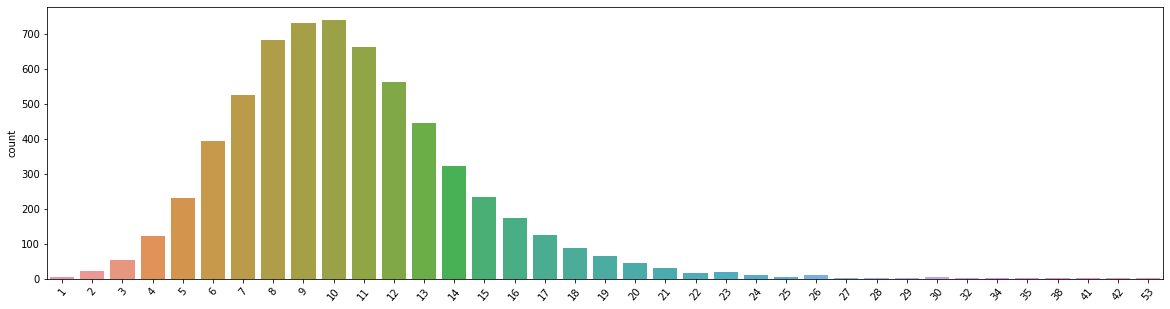

In [ ]:
#可視化標題字數的平均次數
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
g = sns.countplot(x=titles_len)
g.set_xticklabels(g.get_xticklabels(), rotation=50)
plt.show()

In [ ]:
#內文的平均長度
texts = [text for text in df.text]
max_len = 0
texts_len = []
for text in texts:
    texts_len.append(len(text.split()))
    max_len = max(len(text.split()), max_len)
print('Mean length of the texts:', np.mean(texts_len))

Mean length of the texts: 776.3007103393844


In [ ]:
#標籤轉換(REAL:0,FAKE:1)並打散資料集的順序
from sklearn.utils import shuffle
df = df.drop(['text'],axis=1)
df = shuffle(df).reset_index(drop=True)
df["label"]=df.label.map({'REAL':0,'FAKE':1})
display(df)

,title,label
0,Protesters try to block access to Trump rally ...,0
1,Travel: Conor McGregor’s Guide To New York,1
2,See Which 2016 Candidates Best Align With Your...,0
3,Rise of Mandatory Vaccinations Means the End o...,1
4,Netanyahu warns that nuclear deal ‘paves Iran’...,0
...,...,...
6330,Joint Way Forward Deal Does Not Lead to Peace ...,1
6331,"Fiery Republican race heads to S.C., known for...",0
6332,29 of Hillary's scandals: The early years,1
6333,The Fantasy of a Better Iran Deal,0


In [ ]:
#字詞正則化
def irrelevant(text):
    return re.sub('[^a-zA-Z0-9]',' ',text)
df['title']=df['title'].apply(irrelevant)
print(df['title'].head())

0    Protesters try to block access to Trump rally ...
1           Travel  Conor McGregor s Guide To New York
2    See Which 2016 Candidates Best Align With Your...
3    Rise of Mandatory Vaccinations Means the End o...
4    Netanyahu warns that nuclear deal  paves Iran ...
Name: title, dtype: object


In [ ]:
#將字母轉換為小寫
def lowering(text):
    return str(text).lower()
df['title']=df['title'].apply(lowering)
print(df['title'].head())

0    protesters try to block access to trump rally ...
1           travel  conor mcgregor s guide to new york
2    see which 2016 candidates best align with your...
3    rise of mandatory vaccinations means the end o...
4    netanyahu warns that nuclear deal  paves iran ...
Name: title, dtype: object


In [ ]:
#分割資料集(訓練:60%、測試:20%、驗證20%)
train,validate,test=np.split(df.sample(frac=1),[int(.6*len(df)), int(.8*len(df))])
train_df=train.reset_index(drop=True)
val_df=validate.reset_index(drop=True)
test_df=test.reset_index(drop=True)
print('訓練集維度: ',train_df.shape)
print('測試集維度: ',val_df.shape)
print('驗證集維度: ',test_df.shape)

訓練集維度:  (3801, 2)
測試集維度:  (1267, 2)
驗證集維度:  (1267, 2)


In [ ]:
#將所有資料集另存
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)
df=pd.concat([train_df, val_df, test_df])
display(df)

,title,label
0,town in wisconsin passes law that fines parent...,1
1,i watched megyn kelly for six weeks how i lea...,0
2,rand paul i won the debate last night,0
3,japan approves already dead tpp deal,1
4,the polls can no longer be rigged this election,1
...,...,...
1262,lester holt presidential debate moderator and...,0
1263,first take a great jobs report for investors,0
1264,just in republicans sued over trump s call to...,1
1265,world proud of its calm measured response to ...,1


In [ ]:
#安裝XLNet套件
!pip install transformers
import torch
from transformers import XLNetTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#載入預訓練模型
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
#載入檔案至XLNet預訓練模型當中
from torch.utils.data import Dataset
class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
            
        # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
        
#         # 第二個句子的 BERT tokens
#         tokens_b = self.tokenizer.tokenize(text_b)
#         word_pieces += tokens_b + ["[SEP]"]
#         len_b = len(word_pieces) - len_a
        
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 3801
valset size: 1267
testset size:  1267


In [ ]:
#觀察原文與經過變換器轉換的tensor
# 選擇第一個樣本
sample_idx = 25

# 將原始文本拿出做比較
statement, label = trainset.df.iloc[sample_idx].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

# 渲染前後差異，毫無反應就是個 print。可以直接看輸出結果
print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
sex and the presidential city

tokens: 
['<unk>', '▁sex', '▁and', '▁the', '▁presidential', '▁city', '<unk>']

label: 1

--------------------

tokens_tensor: 
tensor([   0, 2216,   21,   18, 1748,  285,    0])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0])

label_tensor: 
1




In [ ]:
#重新建構資料並擬和模型
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 這個函式的輸入 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 16 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [ ]:
#觀察DataLoader當中所有tensor的元素與維度
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([16, 31]) 
tensor([[    0,   584,    25,    17, 29179,  4762,   431,    29, 13977,  1179,
            20,  6446,  1513,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [    0,    17,   150,  2788,   110,  3597,   180,    17,  7617,   111,
            28,   404,   754,   160,    17,   150,  2350,    22,   422, 10570,
            18,    17, 13894,   546, 13336,  2138,     0,     0,     0,     0,
             0],
        [    0,    17, 15306,  7063,  1797,    17,   150,   282,    18,  2317,
           129,   391,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [    0,    17, 26526,  7019,    23,   427,  1127,    17,    46,  4497,
           629,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,   

In [ ]:
#建立XLNet模型
!pip install sentencepiece
from transformers import XLNetForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "xlnet-base-cased"
NUM_LABELS = 2

model = XLNetForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

# high-level 顯示此模型裡的 modules
print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
transformer      XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): Lay

In [ ]:
#顯示XLNet模型使用的config細節
model.config

XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.26.0",
  "untie_r": true,
  "use_mems_eval": true,
  "use_mems_train": false,
  "vocab_size": 32000
}

In [ ]:
#XLNet模型微調優化與訓練
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS =3

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        # 紀錄當前 batch loss
        train_loss += loss.item()

        # if batch_idx == len(trainloader)-1:
        #     _, acc = get_predictions(model, trainloader, compute_acc=True)

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

device: cuda:0


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
#儲存訓練完成的模型
torch.save(model, './best_model.pth')
print('Model saved!')

Model saved!


In [ ]:
#模型績效評估:應用測試集真實值和模型預測值
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

In [ ]:
#產生真實標籤與預測標籤報表
df = pd.DataFrame({"predict_label": predictions})

df_test = pd.concat([testset.df.loc[:, ['title']], 
                          testset.df.loc[:, ['label']], 
                          df.loc[:, 'predict_label']], axis=1)
test_report=df_test.to_excel("report.xlsx")

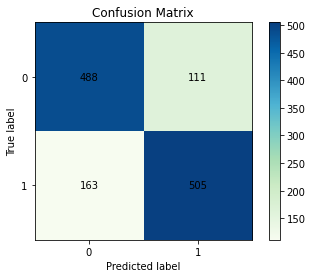

In [ ]:
#繪製混淆矩陣
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y),horizontalalignment='center',verticalalignment='center')
    plt.title('Confusion Matrix')    
    plt.ylabel('True label')         
    plt.xlabel('Predicted label')     
    tick_marks = np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.show()
from sklearn import metrics
confusion_mat=metrics.confusion_matrix(df_test.label, df_test.predict_label,labels=None,sample_weight=None)
plot_confusion_matrix(confusion_mat)

In [ ]:
#產生分類報告
from sklearn.metrics import classification_report
print(classification_report(df_test.label, df_test.predict_label,digits=4))

              precision    recall  f1-score   support

           0     0.8147    0.7496    0.7808       651
           1     0.7560    0.8198    0.7866       616

    accuracy                         0.7837      1267
   macro avg     0.7853    0.7847    0.7837      1267
weighted avg     0.7862    0.7837    0.7836      1267



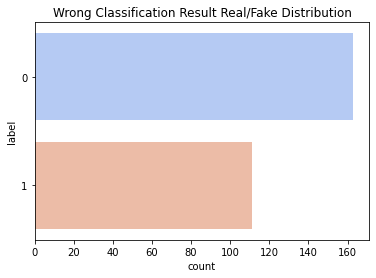

In [ ]:
#找出分類錯誤的label並視覺化
wrong_df = df_test[df_test.label != df_test.predict_label]
sns.countplot(y="label", palette="coolwarm", data=wrong_df).set_title('Wrong Classification Result Real/Fake Distribution')
plt.show()

In [ ]:
#找出分類錯誤的文章
wrong_titles=df_test[df_test.label != df_test.predict_label].title.values
wrong_titles=pd.DataFrame(wrong_titles)
wrong_report=wrong_titles.to_excel("CCPD_WrongArticle.xlsx")